# Keypoint Classification (Two-Handed ISL Model)

In [25]:
import csv
import numpy as np
import tensorflow as tf
import os
import time
import shutil # For copying label file
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path
# !!! IMPORTANT: Update these paths if your files are named differently !!!

In [ ]:
# MODIFIED: Point to the 2-handed dataset CSV
dataset_path = 'model_isl/keypoint_classifier/keypoint.csv'
# MODIFIED: Define path to the corresponding label file for saving later
# This assumes your labels are in a file named like this.
# This file should contain one label per line, matching the class indices (0, 1, 2...)
label_dataset_path = 'model_isl/keypoint_classifier/keypoint_classifier_label.csv' 

# MODIFIED: Define output paths for the 2-handed model
model_base_dir = 'model_isl/keypoint_classifier' # Base directory for ISL model files
model_save_path = os.path.join(model_base_dir, 'keypoint_classifier.h5')
tflite_save_path = os.path.join(model_base_dir, 'keypoint_classifier.tflite')
label_save_path = os.path.join(model_base_dir, 'keypoint_classifier.csv') # Where to save the label file copy

# Ensure the model directory exists
os.makedirs(model_base_dir, exist_ok=True)

# Set number of classes
# MODIFIED: Update this if your number of ISL gestures is different from the original 36

In [27]:
# Assuming 36 classes for now (A-Z, 0-9)
NUM_CLASSES = 36

# Dataset reading

In [28]:
# MODIFIED: Load 84 features (21 landmarks * 2 coords * 2 hands)
# Features are expected in columns 1 to 84 (inclusive)
NUM_FEATURES = 21 * 2 * 2 # 84
X_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, NUM_FEATURES + 1)))

In [29]:
# Labels are expected in column 0
y_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [31]:
model = tf.keras.models.Sequential([
    # MODIFIED: Input shape is now 84 features
    tf.keras.layers.Input((NUM_FEATURES, )),
    tf.keras.layers.Dropout(0.2),
    # Adjusted dense layer units slightly for larger input, can be tuned
    tf.keras.layers.Dense(40, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [32]:
# Note: Param # updated manually based on layer changes
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 84)                0         
                                                                 
 dense_3 (Dense)             (None, 40)                3400      
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 36)                756       
                                                                 
Total params: 4976 (19.44 KB)
Trainable params: 4976 (19.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Model checkpoint callback (uses updated model_save_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1, monitor='val_loss', mode='min', restore_best_weights=True)

In [34]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [35]:
# NOTE: Ensure you have enough data in your 2-handed CSV for effective training!
history = model.fit(
    X_train,
    y_train,
    epochs=1000, # Early stopping will likely trigger before this
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
218/247 [=========================>....] - ETA: 0s - loss: 2.6074 - accuracy: 0.2642
Epoch 1: val_loss improved from inf to 1.22348, saving model to model_isl\keypoint_classifier.h5
247/247 [==============================] - 2s 4ms/step - loss: 2.4952 - accuracy: 0.2928 - val_loss: 1.2235 - val_accuracy: 0.7207
Epoch 2/1000
 44/247 [====>.........................] - ETA: 0s - loss: 1.5198 - accuracy: 0.5423

C:\Users\Dan N Mecartin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/247 [============================>.] - ETA: 0s - loss: 1.3193 - accuracy: 0.6040
Epoch 2: val_loss improved from 1.22348 to 0.78962, saving model to model_isl\keypoint_classifier.h5
247/247 [==============================] - 1s 3ms/step - loss: 1.3168 - accuracy: 0.6048 - val_loss: 0.7896 - val_accuracy: 0.8513
Epoch 3/1000
224/247 [==========================>...] - ETA: 0s - loss: 1.0190 - accuracy: 0.6956
Epoch 3: val_loss improved from 0.78962 to 0.54893, saving model to model_isl\keypoint_classifier.h5
247/247 [==============================] - 1s 3ms/step - loss: 1.0087 - accuracy: 0.6985 - val_loss: 0.5489 - val_accuracy: 0.8726
Epoch 4/1000
241/247 [============================>.] - ETA: 0s - loss: 0.8378 - accuracy: 0.7458
Epoch 4: val_loss improved from 0.54893 to 0.42219, saving model to model_isl\keypoint_classifier.h5
247/247 [==============================] - 1s 2ms/step - loss: 0.8369 - accuracy: 0.7460 - val_loss: 0.4222 - val_accuracy: 0.9430
Epoch 5/1000
218/247 [=

# Plot training history (Optional)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001FE59BDCA60>>
Traceback (most recent call last):
  File "C:\Users\Dan N Mecartin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


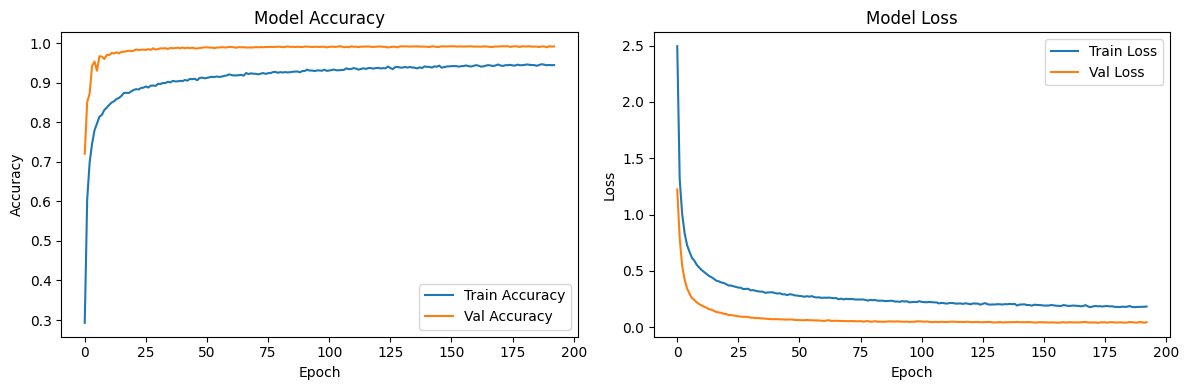

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
# Model evaluation (using the best weights restored by EarlyStopping)
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Loading the best saved model (optional, as EarlyStopping might restore it)

In [ ]:
# Loading the saved model (best one saved by ModelCheckpoint)
print(f"Loading best model from: {model_save_path}")
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print("Sample Prediction Probabilities:", np.squeeze(predict_result))
print("Predicted Class Index:", np.argmax(np.squeeze(predict_result)))
print("Actual Class Index:", y_test[0])

# Confusion matrix & Classification Report

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    # Use labels from 0 to NUM_CLASSES-1 for consistency
    labels = list(range(NUM_CLASSES))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 8)) # Adjusted size
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap='Blues') # Added cmap
    ax.set_ylim(NUM_CLASSES, 0)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    if report:
        print('\nClassification Report')
        # Use zero_division=0 to handle labels with no predictions
        print(classification_report(y_test, y_pred, labels=labels, target_names=[str(i) for i in labels], zero_division=0))

# Predict all test data
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save the final Keras model (optional, best one already saved by callback)
# model.save(model_save_path)

# Load the best model explicitly before conversion
print(f"Loading best model from {model_save_path} for TFLite conversion.")
converter_model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Transform model (quantization)
print(f"Converting model to TFLite: {tflite_save_path}")
converter = tf.lite.TFLiteConverter.from_keras_model(converter_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)
print("TFLite model saved.")

# Save Label File

In [ ]:
# Copy the label file used for training to the model directory
if os.path.exists(label_dataset_path):
    try:
        print(f"Copying label file from {label_dataset_path} to {label_save_path}")
        shutil.copyfile(label_dataset_path, label_save_path)
        print("Label file saved.")
    except Exception as e:
        print(f"Error copying label file: {e}")
else:
    print(f"Warning: Input label file not found at {label_dataset_path}. Cannot save label file.")

# Inference test with TFLite model

In [ ]:
print(f"Loading TFLite model: {tflite_save_path}")
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("TFLite Input Details:", input_details)
print("TFLite Output Details:", output_details)

In [ ]:
# Prepare test data (needs to be float32 and correct shape)
test_index = 0
input_data = np.array([X_test[test_index]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
# Inference implementation
start_time = time.time()
interpreter.invoke()
end_time = time.time()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(f"TFLite Inference Time: {(end_time - start_time)*1000:.2f} ms")

In [ ]:
print("TFLite Prediction Probabilities:", np.squeeze(tflite_results))
predicted_index = np.argmax(np.squeeze(tflite_results))
print("TFLite Predicted Class Index:", predicted_index)
print("Actual Class Index:", y_test[test_index])

# Optional: Load labels to show predicted label name
if os.path.exists(label_save_path):
    with open(label_save_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
        if 0 <= predicted_index < len(labels):
            print("TFLite Predicted Label:", labels[predicted_index])
        if 0 <= y_test[test_index] < len(labels):
             print("Actual Label:", labels[y_test[test_index]])